In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torchvision.datasets import CIFAR100


# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations (normalize + augmentation)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100
trainset = CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = CIFAR100(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Class labels
classes = trainset.classes  # list of 100 class names


100%|██████████| 169M/169M [00:16<00:00, 10.2MB/s]


In [3]:
class CustomCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 100)  # Change from 10 → 100

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [8]:
def train_model(model, trainloader, criterion, optimizer, epochs=10):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader):.4f}")


In [11]:
def evaluate_model(model, testloader):
    model.to(device)
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Classification Report (optional, still useful)
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap='Blues', cbar=True)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.xticks([], [])  # Remove x-axis ticks
    plt.yticks([], [])  # Remove y-axis ticks
    plt.show()


Epoch 1/10, Loss: 3.8028
Epoch 2/10, Loss: 3.2541
Epoch 3/10, Loss: 3.0154
Epoch 4/10, Loss: 2.8574
Epoch 5/10, Loss: 2.7487
Epoch 6/10, Loss: 2.6524
Epoch 7/10, Loss: 2.5957
Epoch 8/10, Loss: 2.5363
Epoch 9/10, Loss: 2.4847
Epoch 10/10, Loss: 2.4426
               precision    recall  f1-score   support

        apple       0.63      0.75      0.68       100
aquarium_fish       0.41      0.55      0.47       100
         baby       0.30      0.34      0.32       100
         bear       0.14      0.28      0.19       100
       beaver       0.26      0.12      0.16       100
          bed       0.35      0.33      0.34       100
          bee       0.45      0.45      0.45       100
       beetle       0.34      0.56      0.42       100
      bicycle       0.45      0.58      0.50       100
       bottle       0.43      0.59      0.50       100
         bowl       0.27      0.32      0.29       100
          boy       0.35      0.29      0.32       100
       bridge       0.49      0.3

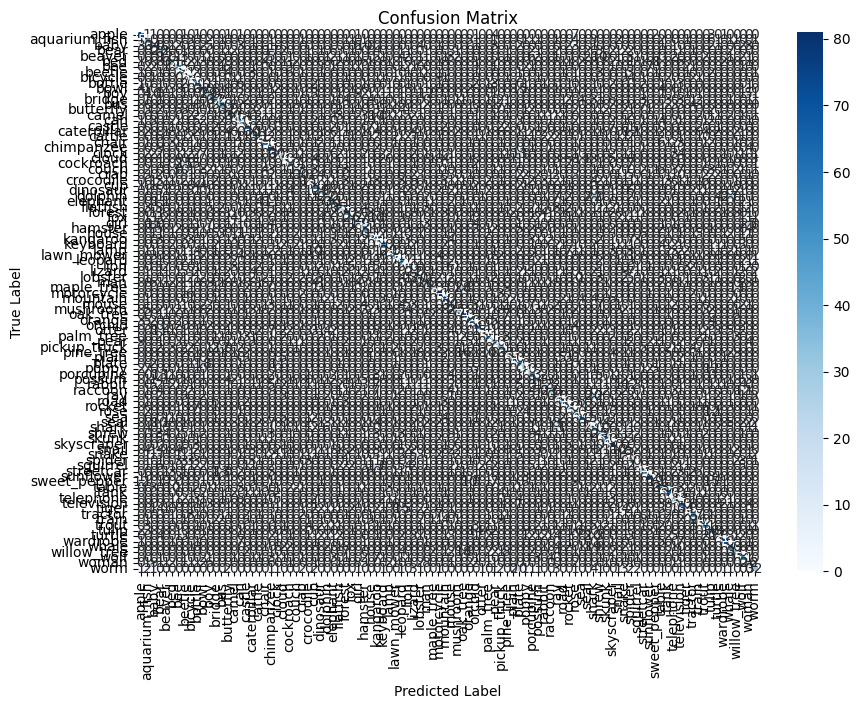

In [5]:
model = CustomCNN(dropout_rate=0.3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, trainloader, criterion, optimizer, epochs=10)



              precision    recall  f1-score   support

           0       0.46      0.72      0.56       100
           1       0.34      0.42      0.38       100
           2       0.33      0.13      0.19       100
           3       0.22      0.11      0.15       100
           4       0.12      0.05      0.07       100
           5       0.25      0.33      0.28       100
           6       0.38      0.22      0.28       100
           7       0.25      0.35      0.29       100
           8       0.34      0.35      0.34       100
           9       0.49      0.33      0.39       100
          10       0.15      0.10      0.12       100
          11       0.32      0.12      0.18       100
          12       0.34      0.21      0.26       100
          13       0.19      0.40      0.25       100
          14       0.22      0.21      0.21       100
          15       0.16      0.12      0.14       100
          16       0.30      0.27      0.29       100
          17       0.30    

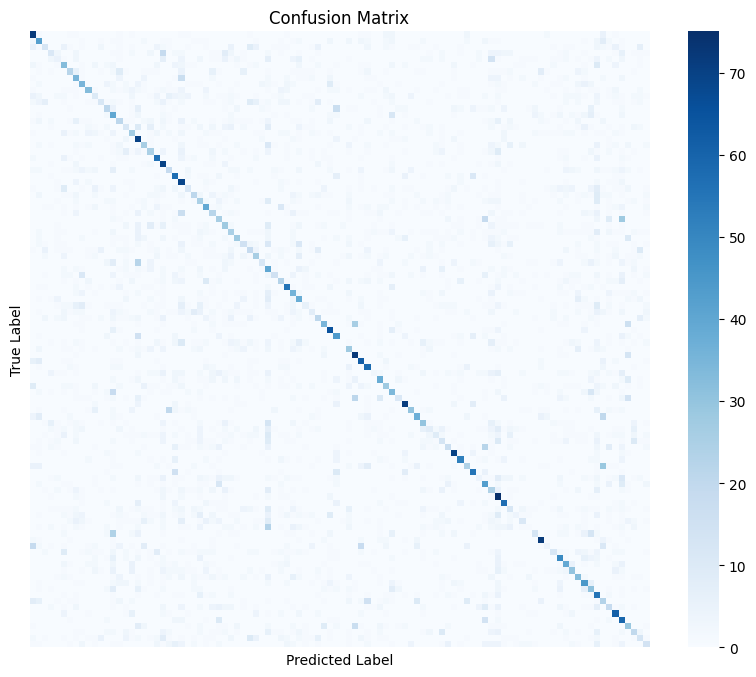

In [12]:
evaluate_model(model, testloader)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 218MB/s]


Epoch 1/5, Loss: 2.8875
Epoch 2/5, Loss: 2.2287
Epoch 3/5, Loss: 1.9940
Epoch 4/5, Loss: 1.8500
Epoch 5/5, Loss: 1.7289
               precision    recall  f1-score   support

        apple       0.75      0.81      0.78       100
aquarium_fish       0.70      0.71      0.71       100
         baby       0.37      0.46      0.41       100
         bear       0.36      0.17      0.23       100
       beaver       0.33      0.20      0.25       100
          bed       0.52      0.51      0.51       100
          bee       0.43      0.67      0.52       100
       beetle       0.52      0.54      0.53       100
      bicycle       0.86      0.54      0.66       100
       bottle       0.70      0.64      0.67       100
         bowl       0.53      0.31      0.39       100
          boy       0.32      0.27      0.29       100
       bridge       0.55      0.63      0.59       100
          bus       0.53      0.21      0.30       100
    butterfly       0.46      0.55      0.50       100

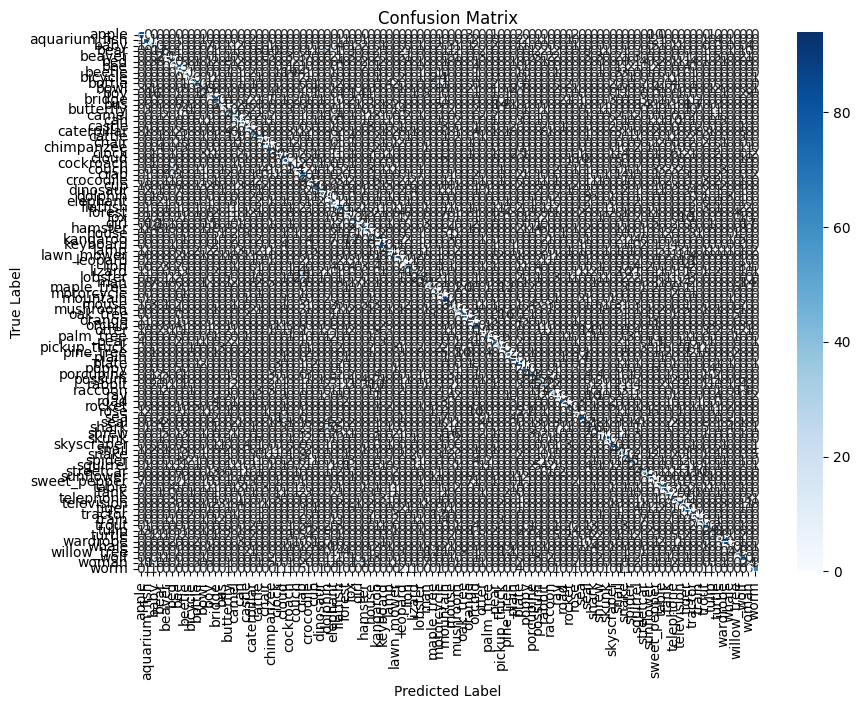

In [6]:
from torchvision.models import resnet18

model_resnet = resnet18(pretrained=True)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 100)  # 100 classes
model_resnet.to(device)


# Optimizer & loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.0005)

# Train
train_model(model_resnet, trainloader, criterion, optimizer, epochs=5)
evaluate_model(model_resnet, testloader)


              precision    recall  f1-score   support

           0       0.75      0.81      0.78       100
           1       0.70      0.71      0.71       100
           2       0.37      0.46      0.41       100
           3       0.36      0.17      0.23       100
           4       0.33      0.20      0.25       100
           5       0.52      0.51      0.51       100
           6       0.43      0.67      0.52       100
           7       0.52      0.54      0.53       100
           8       0.86      0.54      0.66       100
           9       0.70      0.64      0.67       100
          10       0.53      0.31      0.39       100
          11       0.32      0.27      0.29       100
          12       0.55      0.63      0.59       100
          13       0.53      0.21      0.30       100
          14       0.46      0.55      0.50       100
          15       0.42      0.42      0.42       100
          16       0.61      0.56      0.58       100
          17       0.71    

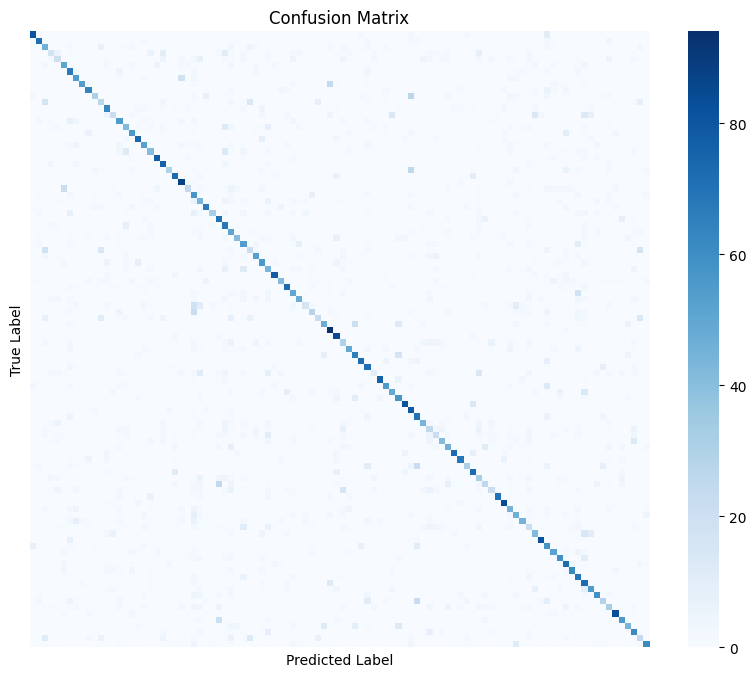

In [13]:
evaluate_model(model_resnet, testloader)


Training with dropout=0.3, lr=0.001
Epoch 1/5, Loss: 3.7998
Epoch 2/5, Loss: 3.2756
Epoch 3/5, Loss: 3.0259
Epoch 4/5, Loss: 2.8565
Epoch 5/5, Loss: 2.7289
              precision    recall  f1-score   support

           0       0.67      0.59      0.63       100
           1       0.39      0.44      0.41       100
           2       0.27      0.35      0.30       100
           3       0.20      0.10      0.13       100
           4       0.04      0.01      0.02       100
           5       0.36      0.21      0.27       100
           6       0.30      0.46      0.37       100
           7       0.25      0.50      0.33       100
           8       0.33      0.50      0.40       100
           9       0.58      0.49      0.53       100
          10       0.22      0.21      0.22       100
          11       0.37      0.16      0.22       100
          12       0.59      0.22      0.32       100
          13       0.36      0.27      0.31       100
          14       0.29      0.3

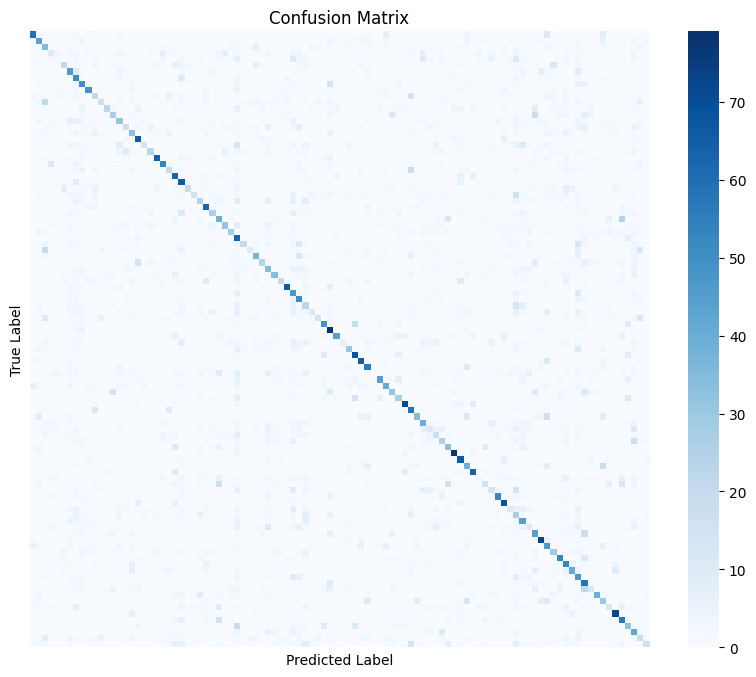


Training with dropout=0.3, lr=0.0005
Epoch 1/5, Loss: 3.8646


In [ ]:
dropouts = [0.3, 0.5]
learning_rates = [0.001, 0.0005]

for d in dropouts:
    for lr in learning_rates:
        print(f"\nTraining with dropout={d}, lr={lr}")
        model = CustomCNN(dropout_rate=d)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        train_model(model, trainloader, criterion, optimizer, epochs=5)
        evaluate_model(model, testloader)
